In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [27]:
#nltk.download('punkt')

NameError: name 'nltk' is not defined

In [2]:
vgsales = pd.read_csv('vgsales.csv')
video_game_sales = pd.read_csv('Video_Games_Sales_as_at_22_Dec_2016.csv')
game_reviews = pd.read_csv('metacritic_critic_reviews.csv')

In [3]:
vgsales.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [4]:
video_game_sales.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
game_reviews.head()

,name,review,game,platform,score,date
0,LEVEL (Czech Republic),"Portal 2 is a masterpiece, a work of art that ...",Portal 2,PC,100.0,"May 25, 2011"
1,GameCritics,So do we need Portal 2? Do I need it? Maybe no...,Portal 2,PC,100.0,"May 8, 2011"
2,PC Games (Russia),Portal 2 exceeds every expectation. It has a s...,Portal 2,PC,100.0,"May 6, 2011"
3,Adventure Gamers,"Like its predecessor, Portal 2 is not an adven...",Portal 2,PC,100.0,"Apr 29, 2011"
4,Armchair Empire,"Pile on the ""Oh, yes!"" moments of solving some...",Portal 2,PC,100.0,"Apr 28, 2011"


In [6]:
#Get the unique game names from vgsales
vgsales['Name'] = vgsales['Name'].str.lower()
unique_vgsales = vgsales.groupby(['Name','Platform']).count()
unique_vgsales.reset_index(drop = False, inplace = True)
unique_vgsales = unique_vgsales.iloc[:,0:2]
print(unique_vgsales.shape)
unique_vgsales.head()

(16593, 2)


,Name,Platform
0,'98 koshien,PS
1,.hack//g.u. vol.1//rebirth,PS2
2,.hack//g.u. vol.2//reminisce,PS2
3,.hack//g.u. vol.2//reminisce (jp sales),PS2
4,.hack//g.u. vol.3//redemption,PS2


In [7]:
#Get the unique game names from video_game_sales
video_game_sales['Name'] = video_game_sales['Name'].str.lower()
unique_video_game_sales = video_game_sales.groupby(['Name','Platform']).count()
unique_video_game_sales.reset_index(drop = False, inplace = True)
unique_video_game_sales = unique_video_game_sales.iloc[:,0:2]
print(unique_video_game_sales.shape)
unique_video_game_sales.head()

(16713, 2)


,Name,Platform
0,beyblade burst,3DS
1,fire emblem fates,3DS
2,frozen: olaf's quest,3DS
3,frozen: olaf's quest,DS
4,haikyu!! cross team match!,3DS


In [8]:
#Change the platform format in game_reviews to make them aligned with the other two tables
game_reviews.replace("PlayStation 4", "PS4", inplace=True)
game_reviews.replace("PlayStation Vita", "PSV", inplace=True)
game_reviews.replace("Wii U", "WiiU", inplace=True)
game_reviews.replace("Xbox One", "XOne", inplace=True)

In [9]:
#Get the unique game names from game_reviews
game_reviews['game'] = game_reviews['game'].str.lower()
unique_game_reviews = game_reviews.groupby(['game','platform']).count()
unique_game_reviews.reset_index(drop = False, inplace = True)
unique_game_reviews = unique_game_reviews.iloc[:,0:2]
print(unique_game_reviews.shape)
unique_game_reviews.head()

(5516, 2)


,game,platform
0,#idarb,XOne
1,.hack//g.u. last recode,PC
2,.hack//g.u. last recode,PS4
3,0rbitalis,PC
4,1-2-switch,Switch


In [10]:
unique_vgsales.groupby('Platform').count()

,Name
Platform,
2600,133
3DO,3
3DS,509
DC,52
DS,2163
GB,98
GBA,822
GC,556
GEN,27


In [11]:
unique_game_reviews.groupby('platform').count()

,game
platform,
3DS,378
PC,2085
PS4,1374
PSV,254
Switch,484
WiiU,185
XOne,756


In [12]:
#Merge game_reviews to vgsales and video_game_sales
test_merge1 = pd.merge(unique_game_reviews, unique_vgsales, left_on=['game','platform'], right_on=['Name','Platform'], how='inner')
test_merge2 = pd.merge(unique_game_reviews, unique_video_game_sales, left_on=['game','platform'], right_on=['Name','Platform'], how='inner')

In [13]:
print(test_merge1.shape)
test_merge1.head()

(883, 4)


,game,platform,Name,Platform
0,7 days to die,PS4,7 days to die,PS4
1,7 days to die,XOne,7 days to die,XOne
2,7th dragon iii code: vfd,3DS,7th dragon iii code: vfd,3DS
3,a game of thrones: genesis,PC,a game of thrones: genesis,PC
4,ace combat: assault horizon legacy,3DS,ace combat: assault horizon legacy,3DS


In [14]:
print(test_merge2.shape)
test_merge2.head()

(951, 4)


,game,platform,Name,Platform
0,7 days to die,PS4,7 days to die,PS4
1,7 days to die,XOne,7 days to die,XOne
2,7th dragon iii code: vfd,3DS,7th dragon iii code: vfd,3DS
3,a game of thrones: genesis,PC,a game of thrones: genesis,PC
4,ace combat: assault horizon legacy,3DS,ace combat: assault horizon legacy,3DS


It is clear that using video_game_sales will provide us more data points. So I decide to use video_game_sales to merge with game_reviews

In [15]:
merged_game_sale_and_reviews = pd.merge(game_reviews, video_game_sales, left_on=['game','platform'], right_on=['Name','Platform'], how='inner')
print(merged_game_sale_and_reviews.shape)
merged_game_sale_and_reviews.head()

(32779, 22)


,name,review,game,platform,score,date,Name,Platform,Year_of_Release,Genre,...,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,LEVEL (Czech Republic),"Portal 2 is a masterpiece, a work of art that ...",portal 2,PC,100.0,"May 25, 2011",portal 2,PC,2011.0,Shooter,...,0.32,0.0,0.1,0.76,95.0,52.0,8.8,5999.0,Valve Software,E10+
1,GameCritics,So do we need Portal 2? Do I need it? Maybe no...,portal 2,PC,100.0,"May 8, 2011",portal 2,PC,2011.0,Shooter,...,0.32,0.0,0.1,0.76,95.0,52.0,8.8,5999.0,Valve Software,E10+
2,PC Games (Russia),Portal 2 exceeds every expectation. It has a s...,portal 2,PC,100.0,"May 6, 2011",portal 2,PC,2011.0,Shooter,...,0.32,0.0,0.1,0.76,95.0,52.0,8.8,5999.0,Valve Software,E10+
3,Adventure Gamers,"Like its predecessor, Portal 2 is not an adven...",portal 2,PC,100.0,"Apr 29, 2011",portal 2,PC,2011.0,Shooter,...,0.32,0.0,0.1,0.76,95.0,52.0,8.8,5999.0,Valve Software,E10+
4,Armchair Empire,"Pile on the ""Oh, yes!"" moments of solving some...",portal 2,PC,100.0,"Apr 28, 2011",portal 2,PC,2011.0,Shooter,...,0.32,0.0,0.1,0.76,95.0,52.0,8.8,5999.0,Valve Software,E10+


# Embeddings section

Some parts of this section are from the article in the link below.

https://medium.com/@ermolushka/text-clusterization-using-python-and-doc2vec-8c499668fa61

The author demonstrates how to retrieve embeddings from the IMDB reviews. 

In [35]:
#Clean the reviews first
merged_game_sale_and_reviews['review_tokens'] = merged_game_sale_and_reviews['review'].str.lower()
merged_game_sale_and_reviews['review_tokens'] = merged_game_sale_and_reviews['review_tokens'].apply(word_tokenize)
merged_game_sale_and_reviews

,name,review,game,platform,score,date,Name,Platform,Year_of_Release,Genre,...,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,review_tokens
0,LEVEL (Czech Republic),"Portal 2 is a masterpiece, a work of art that ...",portal 2,PC,100.0,"May 25, 2011",portal 2,PC,2011.0,Shooter,...,0.0,0.1,0.76,95.0,52.0,8.8,5999.0,Valve Software,E10+,"[portal, 2, is, a, masterpiece, ,, a, work, of..."
1,GameCritics,So do we need Portal 2? Do I need it? Maybe no...,portal 2,PC,100.0,"May 8, 2011",portal 2,PC,2011.0,Shooter,...,0.0,0.1,0.76,95.0,52.0,8.8,5999.0,Valve Software,E10+,"[so, do, we, need, portal, 2, ?, do, i, need, ..."
2,PC Games (Russia),Portal 2 exceeds every expectation. It has a s...,portal 2,PC,100.0,"May 6, 2011",portal 2,PC,2011.0,Shooter,...,0.0,0.1,0.76,95.0,52.0,8.8,5999.0,Valve Software,E10+,"[portal, 2, exceeds, every, expectation, ., it..."
3,Adventure Gamers,"Like its predecessor, Portal 2 is not an adven...",portal 2,PC,100.0,"Apr 29, 2011",portal 2,PC,2011.0,Shooter,...,0.0,0.1,0.76,95.0,52.0,8.8,5999.0,Valve Software,E10+,"[like, its, predecessor, ,, portal, 2, is, not..."
4,Armchair Empire,"Pile on the ""Oh, yes!"" moments of solving some...",portal 2,PC,100.0,"Apr 28, 2011",portal 2,PC,2011.0,Shooter,...,0.0,0.1,0.76,95.0,52.0,8.8,5999.0,Valve Software,E10+,"[pile, on, the, ``, oh, ,, yes, !, '', moments..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32774,XboxAddict,Despite the lackluster quality with some of it...,ride 2,XOne,70.0,"Mar 7, 2017",ride 2,XOne,2016.0,Racing,...,0.0,0.0,0.01,NaN,NaN,8.2,6.0,Milestone S.r.l,E,"[despite, the, lackluster, quality, with, some..."
32775,ICXM,Ride 2 is a huge improvement over the original...,ride 2,XOne,70.0,"Feb 18, 2017",ride 2,XOne,2016.0,Racing,...,0.0,0.0,0.01,NaN,NaN,8.2,6.0,Milestone S.r.l,E,"[ride, 2, is, a, huge, improvement, over, the,..."
32776,Worth Playing,Ride 2 is certainly an improvement over the or...,ride 2,XOne,65.0,"Mar 9, 2017",ride 2,XOne,2016.0,Racing,...,0.0,0.0,0.01,NaN,NaN,8.2,6.0,Milestone S.r.l,E,"[ride, 2, is, certainly, an, improvement, over..."
32777,TrueAchievements,"Despite the addition of more bikes and tracks,...",ride 2,XOne,60.0,"Oct 13, 2016",ride 2,XOne,2016.0,Racing,...,0.0,0.0,0.01,NaN,NaN,8.2,6.0,Milestone S.r.l,E,"[despite, the, addition, of, more, bikes, and,..."


In [48]:
merged_game_sale_and_reviews['review_tokens'][0]

['portal',
 '2',
 'is',
 'a',
 'masterpiece',
 ',',
 'a',
 'work',
 'of',
 'art',
 'that',
 'you',
 'will',
 'love',
 'for',
 'its',
 'ingenious',
 'story',
 'pop-culture',
 ',',
 'references',
 'to',
 'logical',
 'puzzles',
 'and',
 'co-op',
 'multiplayer',
 '.',
 'definitely',
 'a',
 'candidate',
 'for',
 'game',
 'of',
 'the',
 'year',
 '.',
 '[',
 'issue',
 '#',
 '204',
 ']']

In [50]:
LabeledSentence1 = gensim.models.doc2vec.TaggedDocument
all_content_train = []
j=0
for em in merged_game_sale_and_reviews['review_tokens'].values:
    all_content_train.append(LabeledSentence1(em,[j]))
    j+=1
print('Number of texts processed: ', j)

Number of texts processed:  32779


In [222]:
d2v_model = Doc2Vec(all_content_train, vector_size=3, window=4, min_count=1, workers=4)
d2v_model.train(all_content_train, total_examples=d2v_model.corpus_count, epochs=10)

In [223]:
'''
tagged_reviews = [TaggedDocument(review, [i]) for i, review in enumerate(merged_game_sale_and_reviews['review_tokens'])]
model = Doc2Vec(tagged_reviews, vector_size=50, window=2, min_count=1, workers=4)
'''

"\ntagged_reviews = [TaggedDocument(review, [i]) for i, review in enumerate(merged_game_sale_and_reviews['review_tokens'])]\nmodel = Doc2Vec(tagged_reviews, vector_size=50, window=2, min_count=1, workers=4)\n"

In [224]:
d2v_model.dv[32778]

array([-0.11712863,  0.18171608,  0.40475565], dtype=float32)

In [225]:
x_train = d2v_model.dv[0].reshape(1,-1)
for i in range(1,j):
    x_train = np.append(x_train, d2v_model.dv[i].reshape(1,-1),axis=0)

x_train.shape

(32779, 3)

In [226]:
#Do K-means clustering from the Doc2Vec features
kmeans = KMeans(n_clusters=5, random_state=12345).fit(x_train)
kmeans_labels = kmeans.labels_
kmeans_labels.shape

(32779,)

In [227]:
#Do Truncate SVD for see the clusters in 2D space
svd = TruncatedSVD(n_components=2, n_iter=10, random_state=12345)
transformed_unigrams = svd.fit_transform(x_train)
transformed_unigrams[:5]

array([[-0.08145148,  0.00643936],
       [ 0.06834397, -0.09820177],
       [ 0.18318856, -0.45191002],
       [ 0.86820436,  0.20075166],
       [ 0.4342907 , -0.284473  ]], dtype=float32)

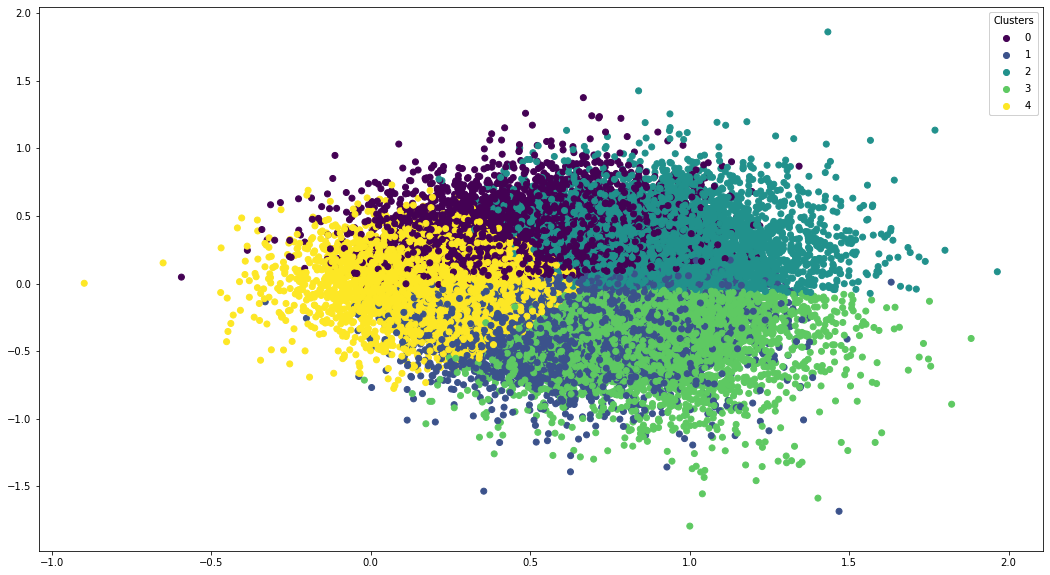

In [228]:
#Visualize the clusters
x = transformed_unigrams[:,0]
y = transformed_unigrams[:,1]
#colors = cm.rainbow(np.linspace(0, 1, y.shape[0]))
fig, ax = plt.subplots(figsize=(18,10))
scatter = ax.scatter(x, y, c=kmeans_labels)
legend1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="Clusters")
ax.add_artist(legend1)
plt.show()

In [231]:
#Evaluate density of the clusters, Mean Silhouette Score
silhouette_score(x_train, kmeans_labels)

#Negative value indicates wrong clustering
#Near zero indicates overlapping clusters
#The best is near 1
#The calculation involves the distance between each sample in the same cluster
#And it also involves the distance between a sample and other samples in the next nearest cluster 

0.22859494

After using the Doc2Vec (An extension of word embeddings), it is obvious that we get the better result, even we didn't fine-tune the parameters yet. The old Mean Silhouette Score is 0.07 and now we get 0.23.  
